In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 2

In [76]:
data = pd.read_csv('portfolio_1.csv')
data

,Date,ACB,VIX,MBB,GMD,HDB
0,5/4/2020,8340,1730,7230,15880,6900
1,5/5/2020,8340,1660,7210,15880,6940
2,5/6/2020,8550,1700,7280,15880,6860
3,5/7/2020,8720,1700,7430,16149,6830
4,5/8/2020,8800,1700,7570,16059,7170
...,...,...,...,...,...,...
966,4/5/2024,27150,19300,23350,78000,23350
967,4/8/2024,27150,18950,23500,77500,23900
968,4/9/2024,27300,19650,24000,78600,23950
969,4/10/2024,27100,19200,23800,79000,23950


In [77]:
def process_data(df):
    # Kiểm tra xem cột 'Date' tồn tại trong DataFrame không
    if 'Date' in df.columns:
        # Chuyển đổi cột 'Date' sang kiểu datetime
        df['Date'] = pd.to_datetime(df['Date'])
        # Đặt cột 'Date' làm chỉ số
        df.set_index('Date', inplace=True)
        # Chia các giá trị trong cột 'ACB' và 'CTG' cho 1000
        df['ACB'] /= 1000
        df['VIX'] /= 1000
        df['MBB'] /= 1000
        df['GMD'] /= 1000
        df['HDB'] /= 1000
        return df
    else:
        print("Không tìm thấy cột 'Date' trong DataFrame.")
data = process_data(data)

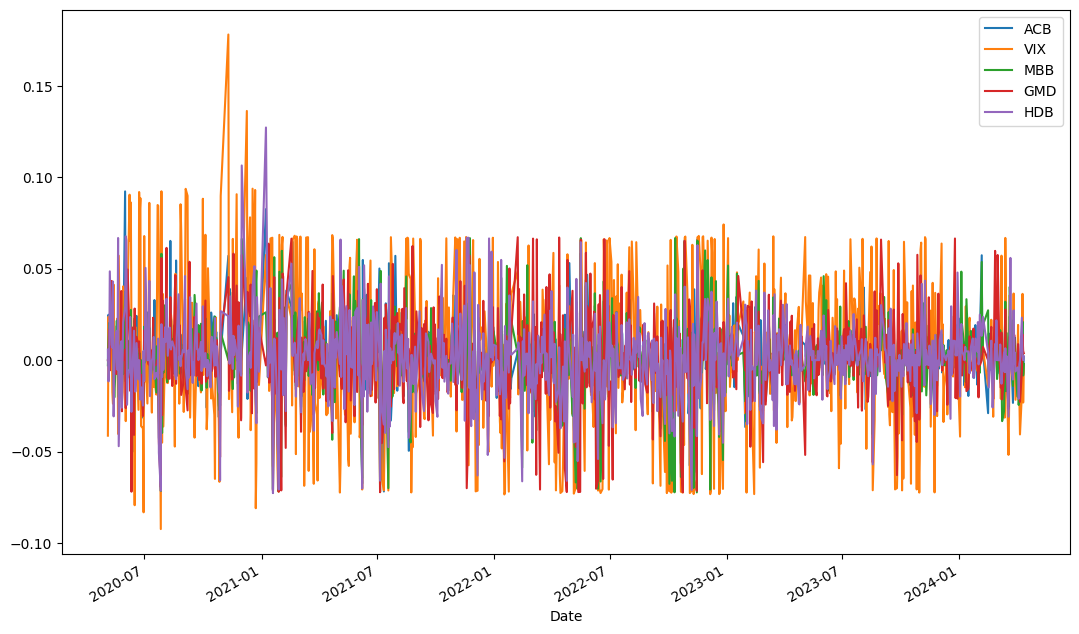

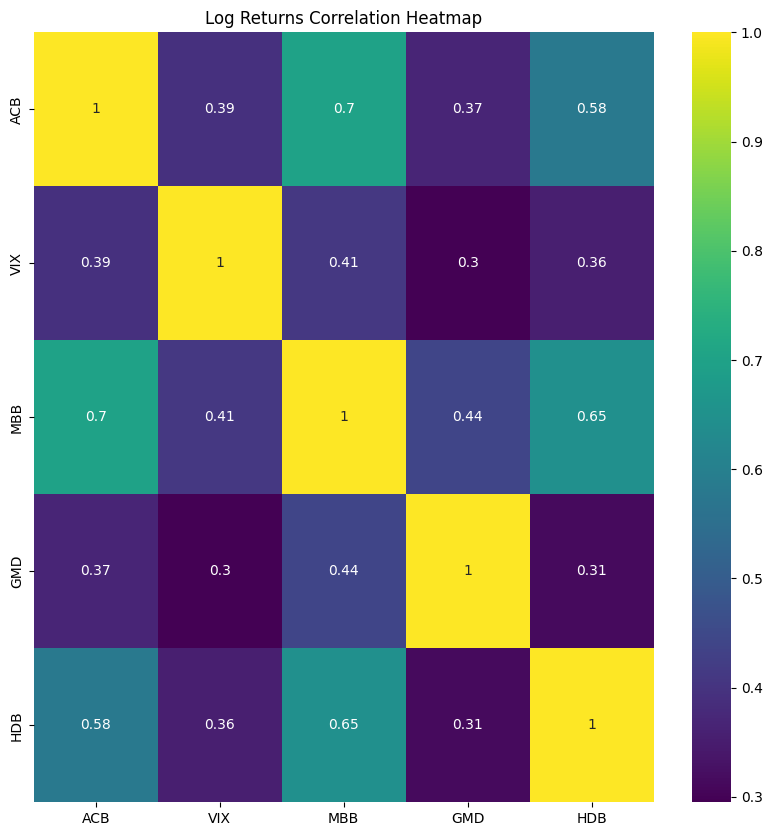

In [78]:
daily_log_returns = np.log(data) - np.log(data.shift(1))
daily_log_returns.plot(figsize=(13, 8))
corr = daily_log_returns.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title('Log Returns Correlation Heatmap')
plt.show()

In [79]:
tickers = ['ACB', 'VIX', 'MBB', 'GMD', 'HDB']
stocks = len(tickers)
weights = np.full((stocks,), 1 / stocks)

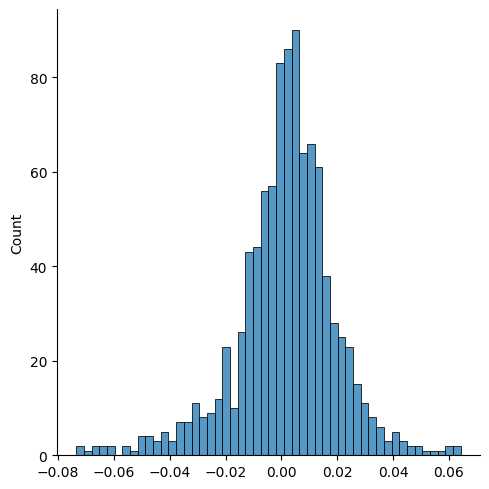

In [80]:
daily_portfolio_returns = daily_log_returns.dot(weights)
sns.displot(daily_portfolio_returns, bins=50)

In [81]:
expected_return = daily_portfolio_returns.mean() * 252
vol = daily_portfolio_returns.std() * np.sqrt(252)
skew = daily_portfolio_returns.skew()
sr = expected_return / vol

print(f"{expected_return=}")
print(f"{vol=}")
print(f"{skew=}")
print(f"{sr=}")

expected_return=0.3963699542673608
vol=0.28697523511975126
skew=-0.5671089969982152
sr=1.3811991620181459


In [82]:
returns = daily_log_returns
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * np.sqrt(252)

# Assuming 'tickers', 'mean_returns', and 'cov_matrix' are already defined
num_portfolios = 10000

# DataFrame to store the results
results = pd.DataFrame(columns=['returns', 'volatility', 'sharpe', 'weights'], index=range(num_portfolios))
# store all weights
weights_record = []

for i in range(num_portfolios):
		# Normalised randomly generated weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

		# Calculate returns and volatility
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

		# Store results
    results.loc[i, 'returns'] = returns
    results.loc[i, 'volatility'] = volatility
    results.loc[i, 'sharpe'] = results.loc[i, 'returns'] / results.loc[i, 'volatility']
    results.loc[i, 'weights'] = ','.join(str(np.round(weight, 4)) for weight in weights)
		# record weights
    weights_record.append(weights)
    
print(results.sort_values('sharpe', ascending=False))

       returns volatility    sharpe                             weights
1108  0.407853   0.071065  5.739193  0.2341,0.1735,0.0191,0.3848,0.1886
6827  0.410773   0.071589  5.737905  0.1981,0.1743,0.0272,0.4078,0.1926
9361  0.409533   0.071382  5.737183  0.2136,0.1648,0.0107,0.4253,0.1856
7044  0.406844   0.070927  5.736119  0.1791,0.1642,0.0173,0.3932,0.2462
9967  0.419116   0.073101  5.733354   0.1844,0.2044,0.0345,0.399,0.1777
...        ...        ...       ...                                 ...
1521  0.318953   0.074615  4.274641  0.0157,0.0058,0.6256,0.0311,0.3218
3909  0.310945   0.072876  4.266767    0.8491,0.0074,0.0525,0.003,0.088
951    0.32482   0.078422  4.141957  0.0475,0.0104,0.1186,0.0045,0.8189
2417  0.313988   0.075916  4.136013  0.1604,0.0097,0.7435,0.0109,0.0755
6177  0.322852   0.078719   4.10134  0.0414,0.0022,0.1151,0.0081,0.8331

[10000 rows x 4 columns]


In [83]:
# Efficient Frontier with max sharpe portfolio and min volatility portfolio
max_sharpe_portfolio = results.iloc[pd.to_numeric(results['sharpe']).idxmax()]
min_volatility_portfolio = results.iloc[pd.to_numeric(results['volatility']).idxmin()]

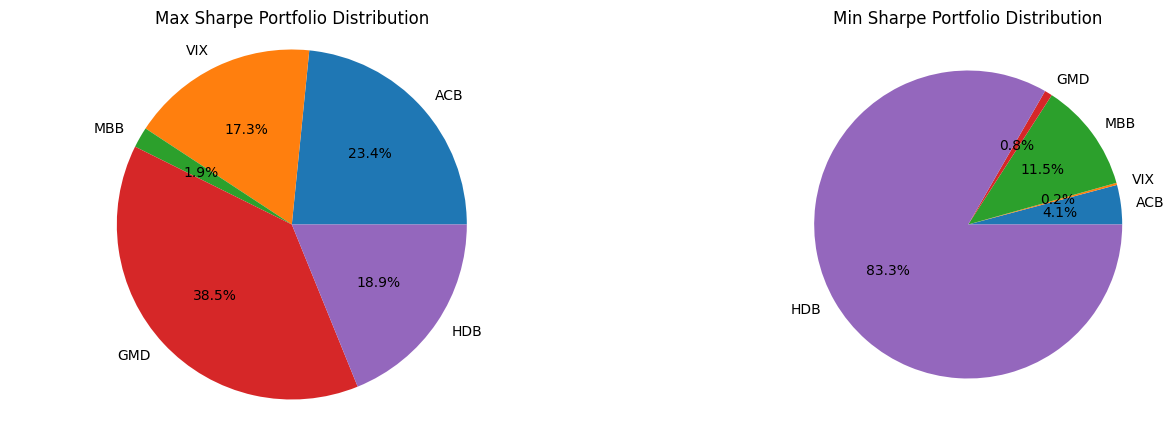

In [84]:
# Get rows with max and min 'sharpe' values
row_max = results.sort_values('sharpe', ascending=False).head(1)
row_min = results.sort_values('sharpe').head(1)

# Split the weights strings and convert to floats
weights_max = [float(x) for x in row_max['weights'].iloc[0].split(',')]
weights_min = [float(x) for x in row_min['weights'].iloc[0].split(',')]

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

# Plotting the max sharpe pie chart
axs[0].pie(weights_max, labels=tickers, autopct='%1.1f%%')
axs[0].set_title('Max Sharpe Portfolio Distribution')
axs[0].axis('equal')  # Equal aspect ratio

# Plotting the min sharpe pie chart
axs[1].pie(weights_min, labels=tickers, autopct='%1.1f%%')
axs[1].set_title('Min Sharpe Portfolio Distribution')
plt.show()